In [1]:
import seaborn as sns
import pandas as pd
import sklearn
import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer
import regex as re
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,HashingVectorizer

from sklearn.feature_extraction import stop_words
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
reddits = pd.read_csv("scraped_data.csv")

In [3]:
reddits.head()

,Unnamed: 0,Titles,Subreddit
0,0,"Plant-Based Meat Sales Rise, Fueled by Carnivores",nottheonion
1,1,Someone is using Gabe Newell’s face to sell un...,nottheonion
2,2,"Coming soon: Brunchables, for when you want Lu...",nottheonion
3,3,'Close Your Legs' Judge in NJ Sex Case Faces S...,nottheonion
4,4,Washington Department of Corrections Quietly B...,nottheonion


In [4]:
#Creating dummy variables for the subreddit column so I can later perform classification regression on this dataset.
reddits = pd.get_dummies(reddits, columns =['Subreddit'], drop_first=True)

In [5]:
#Ensuring that there are no duplicates in my datafame
reddits = reddits.drop_duplicates()

In [6]:
reddits.head()

,Unnamed: 0,Titles,Subreddit_nottheonion
0,0,"Plant-Based Meat Sales Rise, Fueled by Carnivores",1
1,1,Someone is using Gabe Newell’s face to sell un...,1
2,2,"Coming soon: Brunchables, for when you want Lu...",1
3,3,'Close Your Legs' Judge in NJ Sex Case Faces S...,1
4,4,Washington Department of Corrections Quietly B...,1


In [7]:
#Dropping Unnamed:0
reddits = reddits.drop(['Unnamed: 0'], axis = 1)

In [8]:
#Did it work?
reddits.head()

,Titles,Subreddit_nottheonion
0,"Plant-Based Meat Sales Rise, Fueled by Carnivores",1
1,Someone is using Gabe Newell’s face to sell un...,1
2,"Coming soon: Brunchables, for when you want Lu...",1
3,'Close Your Legs' Judge in NJ Sex Case Faces S...,1
4,Washington Department of Corrections Quietly B...,1


# NLP pre-processing

In [9]:
#Checking to make sure there's an even number of both subreddits
reddits['Subreddit_nottheonion'].value_counts()

0    975
1    400
Name: Subreddit_nottheonion, dtype: int64

From just looking through the reddit page, I noticed that there are a few titles with characters. I'm going to create a function that iterates through the dataframe and makes these. 

Additionally, I'm going to make all the strings in the title lowercase and eliminate punctuation. This is to ensure baseline equality between both sets of data, and also ensuring the best possible data for the modeling process

In [10]:
#Lowercase titles
reddits['Titles'] = reddits["Titles"].map(lambda x: x.lower())

In [11]:
#Check
reddits.head(10)

,Titles,Subreddit_nottheonion
0,"plant-based meat sales rise, fueled by carnivores",1
1,someone is using gabe newell’s face to sell un...,1
2,"coming soon: brunchables, for when you want lu...",1
3,'close your legs' judge in nj sex case faces s...,1
4,washington department of corrections quietly b...,1
5,"more condoms, fewer cigarettes found in annual...",1
6,university of kansas offering 'angry white mal...,1
7,arkansas men arrested for taking turns shootin...,1
8,house of commons suspended after water pours t...,1
9,oppo designs phone with a secondary pop-up scr...,1


In [12]:
reddits['Titles'][888]

'elliott abrams defends war crimes as happening back in the ’80s when everyone was doing it'

In [13]:
#Cleaned data csv
reddit_clean = reddits.to_csv('./cleaned_subreddits.csv')

# Establishing baseline accuracy

In [14]:
#Setting X and y variables
X = reddits['Titles']
y = reddits['Subreddit_nottheonion']

In [15]:
#How large is my dataframe of unique columns. Set X is redundant because I dropped duplicates
len(set(X))

1338

In [16]:
#Train/test split
X_train,X_test, y_train, y_test = train_test_split(X, y, 
                                                   stratify = y, 
                                                   random_state = 42)

In [17]:
#baseline accuracy score
y.value_counts(normalize = True)

0    0.709091
1    0.290909
Name: Subreddit_nottheonion, dtype: float64

**So, we know we have a baseline accuracy score of 70.1%. This means our goal is to create a model that predicts our data at better than half the time.** 

# Bag of Words 

In [18]:
train_corpus = reddits['Titles']
test_corpus = reddits['Subreddit_nottheonion']

# Instantiate a CountVectorizer
cvec = CountVectorizer(stop_words='english', ngram_range = (2,2))

# Fit the vectorizer on our corpus
cvec.fit(train_corpus)
#Set X_train
X_train = cvec.transform(train_corpus)
X_test = test_corpus

#CountVectorizer(ngram_range = (2,2)).fit(train_corpus).get_feature_names()

#Dataframe of bag of words at ngrams 2,2
X_train_cvec_2 =pd.DataFrame(X_train.todense(), columns=cvec.get_feature_names())

X_train_cvec_2.describe()

,000 000,000 actual,000 americans,000 boyfriend,000 feet,000 food,000 men,000 new,000 pill,000 pinocchios,...,zero detainees,zero temperatures,zero trace,zion williamson,zoo posting,zoo predict,zoo turn,zoo year,zookeeper special,zuckerberg chased
count,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000,...,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000,1375.000000
mean,0.001455,0.000727,0.000727,0.000727,0.000727,0.000727,0.000727,0.000727,0.000727,0.000727,...,0.001455,0.000727,0.000727,0.001455,0.000727,0.000727,0.000727,0.000727,0.000727,0.000727
std,0.038125,0.026968,0.026968,0.026968,0.026968,0.026968,0.026968,0.026968,0.026968,0.026968,...,0.038125,0.026968,0.026968,0.038125,0.026968,0.026968,0.026968,0.026968,0.026968,0.026968
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
#Making a dataframe of only the top most used words 
num_words = X_train_cvec_2.sum(axis = 0)
word_list = num_words.sort_values(ascending = False).head(30)
print(word_list)

year old             24
super bowl           11
study finds          10
releases new          8
bernie sanders        7
white house           7
area man              7
pope francis          6
harry potter          6
alexandria ocasio     6
supreme court         6
new york              6
ocasio cortez         6
20 years              5
change way            5
things know           5
way watch             5
donald trump          5
roger stone           5
introduces new        5
bryce harper          4
new evidence          4
michael jackson       4
robert mueller        4
climate change        4
high speed            4
high school           4
police say            4
fox news              4
don know              4
dtype: int64


In [20]:
word_count = pd.DataFrame(word_list).reset_index().rename(columns = {"index": 'word', 0: 'count'})

In [21]:
#word_count

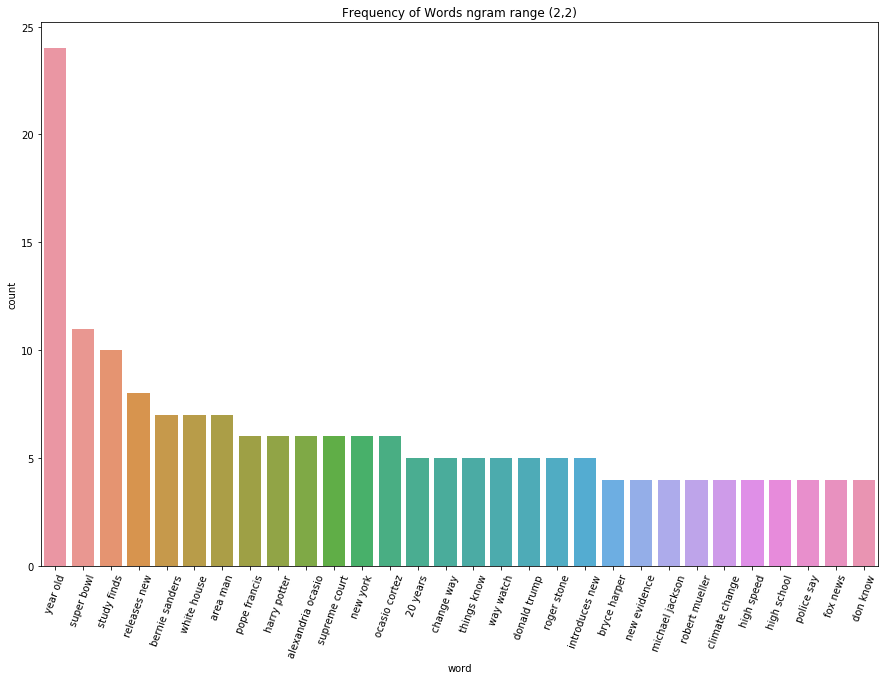

In [22]:
plt.figure(figsize=(15,10))
sns.barplot(x = 'word', y='count', data = word_count)
plt.title('Frequency of Words ngram range (2,2)')
plt.xticks(rotation=70);